# Computational parameters

Discussion of the computational parameters in a TEMPO or PT-TEMPO computation and establishing convergence of results

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fparameters.ipynb) (runs in browser),
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/parameters.ipynb), or
- read through the text below and code along.

# Contents

* [Introduction - numerical exactness and computational parameters](#Introduction---numerical-exactness-and-computational-parameters)
* [Choosing `tcut`](#Choosing-tcut)
  - [Example - memory effects in a spin boson model](#Example---memory-effects-in-a-spin-boson-model)
  - [Discussion - environment correlations](#Discussion---environment-correlations)
* [Choosing `dt` and `epsrel`](#Choosing-dt-and-epsrel)
  - [Example - convergence for a spin boson model](#Example---convergence-for-a-spin-boson-model)
  - [Resolving fast system dynamics](#Resolving-fast-system-dynamics)
* [Further considerations](#Further-considerations)
  - [Additional TempoParameters arguments](#Additional-TempoParameters-arguments)
  - [Bath coupling degeneracies](#Bath-coupling-degeneracies)
* [PT-TEMPO](#PT-TEMPO)

The following packages will be required

In [1]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14.0, 'lines.linewidth':2.50, 'figure.figsize':(8,6)})

The OQuPy version should be `>=0.5.0`

In [2]:
oqupy.__version__

'0.5.0'

# Introduction - numerical exactness and computational parameters
The TEMPO and PT-TEMPO methods are numerically exact meaning no approximations are required in their derivation. Instead error only arises in their numerical implementation, and is controlled by a set of computational parameters. The error can, in principle (at least up to machine precision), be made as small as desired by tuning those numerical parameters. In this tutorial we discuss how this is done to derive accurate results with manageable computational costs.

As introduced in the [Quickstart](https://oqupy.readthedocs.io/en/latest/pages/tutorials/quickstart.html) tutorial a TEMPO or PT-TEMPO calculation has three main computational parameters:

1. A memory cut-off `tcut`, which must be long enough to capture non-Markovian effects of the environment
2. A timestep length `dt`, which must be short enough to avoid Trotter error and provide a sufficient resolution of the system dynamics
3. A precision `epsrel`, which must be small enough such that the numerical compression (singular value truncation) does not incur physical error

In order to verify the accuracy of a calculation, convergence should be established under all three parameters, under increases of `tcut` and decreases `dt` and `epsrel`. The challenge is that these parameters cannot necessarily be considered in isolation, and a balance must be struck between accuracy and computational cost. The strategy we take is to firstly determine a suitable `tcut` (set physically by properties of the environment) with rough values of `dt` and `epsrel`, then determine convergence under `dt->0,epsrel->0`.

We illustrate convergence using the TEMPO method, but the ideas discussed will also generally apply to a PT-TEMPO computation where one first calculates a process tensor - fixing `tcut`, `dt`, `epsrel` - before calculating the system dynamics (see [PT-TEMPO](#PT-TEMPO)). Note some of the calculations in this tutorial may not be suitable to run in a Binder instance. If you want to run them on your own device, you can either copy the code as you go along or [download the .ipynb file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/parameters.ipynb) to run in a local jupyter notebook session. 
Example results for all calculations are embedded in the notebook already, so this is not strictly required.

# Choosing tcut
## Example - memory effects in a spin boson model
We firstly define a spin-boson model similar to that in the Quickstart tutorial, but with a finite temperature environment and a small additional incoherent dissipation of the spin.

In [3]:
sigma_x = oqupy.operators.sigma('x')
sigma_y = oqupy.operators.sigma('y')
sigma_z = oqupy.operators.sigma('z')
sigma_m = oqupy.operators.sigma('-')

omega_cutoff = 2.5
alpha = 0.8
T = 0.2
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=omega_cutoff,
                                cutoff_type='exponential',
                                temperature=T)
bath = oqupy.Bath(0.5 * sigma_z, correlations)
Omega = 2.0
Gamma = 0.02
system = oqupy.System(0.5 * Omega * sigma_x,
                      gammas=[Gamma],
                      lindblad_operators=[sigma_m], # incoherent dissipation
                     )

t_start = 0.0
t_end = 5.0

To determine a suitable set of computational parameters for `t_start<=t<=t_end`, a good place to start is with a call to the `guess_tempo_parameters` function:

In [4]:
guessed_paramsA = oqupy.guess_tempo_parameters(bath=bath,
                                              start_time=t_start,
                                              end_time=t_end,
                                              tolerance=0.01)
print(guessed_paramsA)

../oqupy/tempo.py:865: UserWarning: Estimating TEMPO parameters. No guarantee subsequent dynamics calculations are converged. Please refer to the TEMPO documentation and check convergence by varying the parameters manually.
  warnings.warn(GUESS_WARNING_MSG, UserWarning)


----------------------------------------------
TempoParameters object: Roughly estimated parameters
 Estimated with 'guess_tempo_parameters()' based on bath correlations.
  dt                   = 0.125 
  tcut [dkmax]         = 2.5 [20] 
  epsrel               = 6.903e-05 
  add_correlation_time = None 



As indicated in the description of this object, the parameters were estimated by analysing the correlations of `bath`, which are discussed further below. 

From the suggested parameters, we focus on `tcut` first, assuming the values of `dt` and `epsrel` are reasonable to work with. To do so we compare results at the recommend `tcut` to those calculated at a smaller (`1.25`) and larger (`5.0`) values of this parameter, starting from the spin-up state:

--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:00
Elapsed time: 0.8s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:01
Elapsed time: 1.6s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:01
Elapsed time: 1.9s


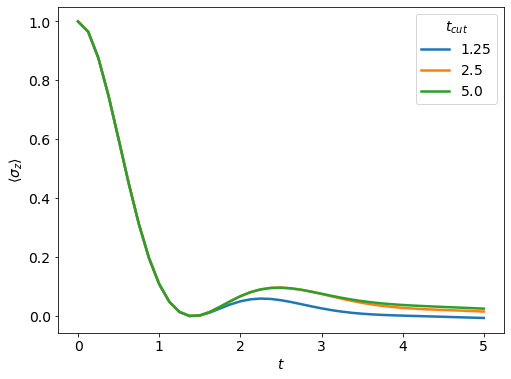

In [5]:
initial_state = oqupy.operators.spin_dm('z+')

for tcut in [1.25,2.5,5.0]:
     # Create TempoParameters object matching those guessed above, except possibly for tcut
    params = oqupy.TempoParameters(dt=0.125, epsrel=6.9e-06, tcut=tcut)
    dynamics = oqupy.tempo_compute(system=system,
                                   bath=bath,
                                   initial_state=initial_state,
                                   start_time=t_start,
                                   end_time=t_end,
                                   parameters=params)
    t, s_z = dynamics.expectations(sigma_z, real=True)
    plt.plot(t, s_z, label=r'${}$'.format(tcut))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend(title=r'$t_{cut}$')

We see that `tcut=2.5` (orange) does very well, matching `tcut=5.0` (green) until essentially the end of the simulation (the precision `epsrel` could well be causing the small discrepancy). We know `tcut=5.0` should capture the actual result, because `tcut=5.0=t_end` means no memory cutoff was made! In general it is not always necessary to make a finite memory approximation. For example, perhaps one is interested in short-time dynamics only. The memory cutoff can be disable by setting `tcut=None`; be aware computation to long times (i.e. many hundreds of timesteps) may then be infeasible.

The `tcut=1.25` result matches the other two exactly until `t=1.25` (no memory approximation is made before this time), but deviates shorlty after. On the other hand, the cost of using the larger `tcut=2.5` was a longer computation: 1.6s vs 0.8s above. This was a trivial example, but in many real calculations the runtimes will be far longer e.g. minutes or hours. It may be that an intermediary value `1.25<=tcut<=2.5` provides a satisfactory approximation - depending on the desired precision - with a more favourable cost: a TEMPO (or PT-TEMPO) computation scales **linearly** with the number of steps included in the memory cutoff.

### A word of warning

`guess_tempo_parameters` provides a reasonable starting point for many cases, but it is only a guess. You should always verify results using a larger `tcut`, whilst also not discounting smaller `tcut` to reduce the computational requirements. Similar will apply to checking convergence under `dt` and `epsrel`.

Also, note we only inspected the expectations $\langle \sigma_z \rangle$. To be most thorough all unique components of the state matrix should be checked, or at least the expectations of observables you are intending to study. So, if you were interested in the coherences as well as the populations, you would want to add calls to calculate $\langle \sigma_x \rangle$, $\langle \sigma_y \rangle$ above (you can check `tcut=2.5` is still good for the above example).

## Discussion - environment correlations
So what influences the required `tcut`? The physically relevant timescale is that for the decay of correlations in the environment. These can be inspected using `oqupy.helpers.plot_correlations_with_parameters`:

<AxesSubplot:>

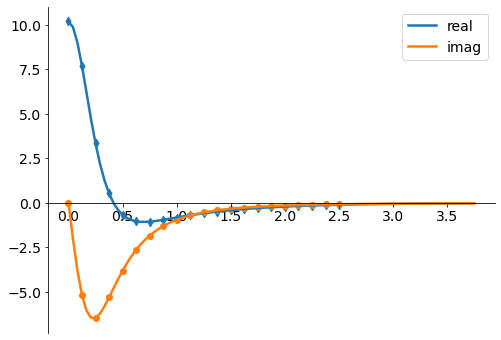

In [6]:
fig, ax = plt.subplots()
params = oqupy.TempoParameters(dt=0.125, epsrel=1, tcut=2.5) # N.B. epsrel not used by helper, and tcut only to set plot t-limits
oqupy.helpers.plot_correlations_with_parameters(bath.correlations, params, ax=ax)

This shows the real and imaginary parts of the bath autocorrelation function, with markers indicating samples of spacing `dt`. We see that correlations have not fully decayed by `t=1.25`, but have - at least by eye - by `t=2.5`. It seems like `tcut` around this value would indeed be a good choice.

The autocorrelation function depends on the properties of the bath: the form the spectral density, the cutoff, and the temperature. These are accounted for by the `guess_tempo_parameters` function, which is really analysing the error in performing integrals of this function. The `tolerance` parameter specifies the maximum absolute error permitted, with an inbuilt default value of `3.9e-3` - passing `tolerance=0.01` made for slightly 'easier' parameters.

Note, however, what is observed in the _system dynamics_ also depends the bath coupling operator and strength (`alpha`), and that these are _not_ taken into account by the guessing function. More generally, the nature of the intrinsic system dynamics (see below) and initial state preparation also has to be considered. 

Finally, the guessing function uses specified `start_time` and `end_time` to come up with parameters providing a manageable computation time over a timescale `end_time-start_time`, so make sure to set these to reflect those you actually intend to use in calculations.  


# Choosing dt and epsrel
## Example - convergence for a spin boson model
Continuing with the previous example, we now investigate changing `dt` at our chosen `tcut=2.5`.

--> TEMPO computation:
100.0%   80 of   80 [########################################] 00:00:03
Elapsed time: 3.0s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:00
Elapsed time: 0.9s
--> TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.3s


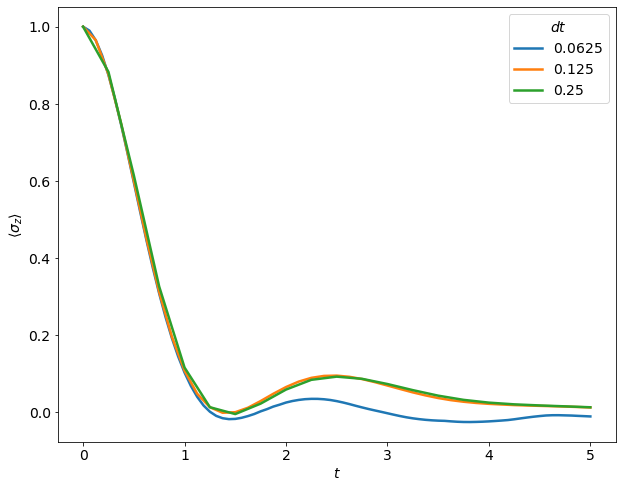

In [7]:
plt.figure(figsize=(10,8))
for dt in [0.0625, 0.125, 0.25]:
    params = oqupy.TempoParameters(dt=dt, epsrel=6.9e-05, tcut=2.5)
    dynamics = oqupy.tempo_compute(system=system,
                                   bath=bath,
                                   initial_state=initial_state,
                                   start_time=t_start,
                                   end_time=t_end,
                                   parameters=params)
    t, s_z = dynamics.expectations(sigma_z, real=True)
    plt.plot(t, s_z, label=r'${}$'.format(dt))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend(title=r'$dt$')

That doesn't look good! If we had just checked `dt=0.25` and `dt=0.125` we may have been happy with the convergence, but a halving of the timestep gave very different results (you can check `dt=0.0625` is even worse).

The catch here is that we used the same precision `epsrel=6.9e-05` for all runs, but `dt=0.125` requires a smaller `epsrel`: halving the timestep _doubles_ the number of steps `dkmax` for which singular value truncations are made in the bath's memory `tcut=dt*dkmax`. 

Let's repeat the calculation with a smaller `epsrel` at `dt=0.125`:

--> TEMPO computation:
100.0%   80 of   80 [########################################] 00:00:04
Elapsed time: 5.0s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:00
Elapsed time: 0.9s
--> TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s


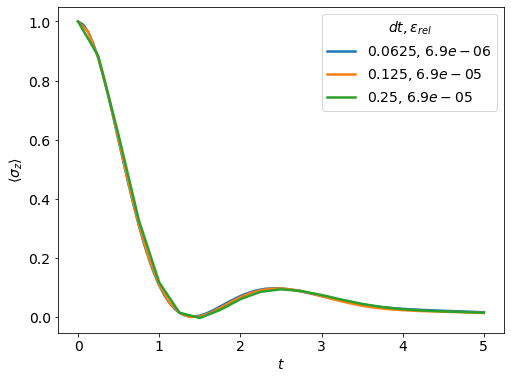

In [8]:
for dt, epsrel in zip([0.0625,0.125, 0.25],[6.9e-06,6.9e-05,6.9e-05]):
    params = oqupy.TempoParameters(dt=dt, epsrel=epsrel, tcut=2.5)
    dynamics = oqupy.tempo_compute(system=system,
                                   bath=bath,
                                   initial_state=initial_state,
                                   start_time=t_start,
                                   end_time=t_end,
                                   parameters=params)
    t, s_z = dynamics.expectations(sigma_z, real=True)
    plt.plot(t, s_z, label=r'${}$, ${:.2g}$'.format(dt,epsrel))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend(title=r'$dt, \epsilon_{rel}$')

That looks far better. The lesson here is that one cannot expect to be able to decrease `dt` at fixed `tcut` without also decreasing `epsrel`. A heuristic used by `guess_tempo_parameters`, which you may find useful, is
$$ \epsilon_{\text{r}} = \text{tol} \cdot 10^{-p},\ p=\log_4 (\text{dkmax}), $$
where tol is a target tolerance (e.g. `tolerance=0.01` above) and `dkmax` the number of steps such that `tcut=dt*dkmax`.

Note `TempoParameters` allows the memory cutoff to be specified as the integer `dkmax` rather than float `tcut`, meaning this estimation of `epsrel` doesn't change with `dt`. However, the author prefers working at a constant `tcut` which is set physically by the decay of correlations in the environment; then one only has to worry about the simultaneous convergence of `dt` and `epsrel`.

Comparing the simulation times at `dt=0.0625` between the previous two sets of results, we see the cost of a smaller `epsrel` is a longer computation (5 vs. 3 seconds). The time complexity of the singular value decompositions in the TEMPO tensor network scales with the **third power** of the internal bond dimension, which is directly controlled by the precision, so be aware that decreasing `epsrel` may lead to rapid increase in computation times.

The last results suggest that we may well already have convergence w.r.t `epsrel` at `dt=0.125`. This should be checked: 

--> TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.3s
--> TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s
--> TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s


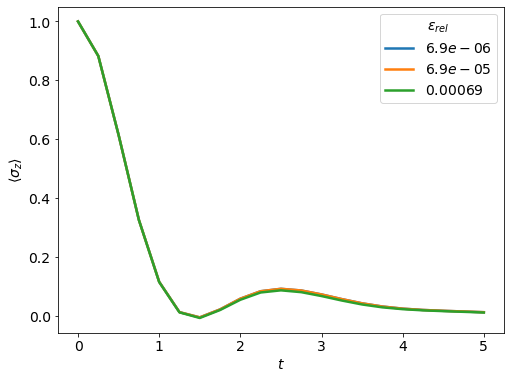

In [9]:
for epsrel in [6.9e-06,6.9e-05,6.9e-04]:
    params = oqupy.TempoParameters(dt=dt, epsrel=epsrel, tcut=2.5)
    dynamics = oqupy.tempo_compute(system=system,
                                   bath=bath,
                                   initial_state=initial_state,
                                   start_time=t_start,
                                   end_time=t_end,
                                   parameters=params)
    t, s_z = dynamics.expectations(sigma_z, real=True)
    plt.plot(t, s_z, label=r'${:.2g}$'.format(epsrel))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend(title=r'$\epsilon_{rel}$')

In summary, we may well be happy with the parameters `dt=0.125`, `epsrel=6.9e-05`, `tcut=2.5` for this model (we could probably use a larger `epsrel`, but the computation is so inexpensive in this example it is hardly necessary). 

So far we have discussed mainly how the environment - namely the memory length - dictates the parameters. We now look at what influence the system can have.

## Resolving fast system dynamics

In the above you may have noticed that the results at `dt=0.125`, while converged, were slightly undersampled. This becomes more noticeable if the scale of the system energies is increased (here by a factor of 4):

../oqupy/tempo.py:865: UserWarning: Estimating TEMPO parameters. No guarantee subsequent dynamics calculations are converged. Please refer to the TEMPO documentation and check convergence by varying the parameters manually.
  warnings.warn(GUESS_WARNING_MSG, UserWarning)


----------------------------------------------
TempoParameters object: Roughly estimated parameters
 Estimated with 'guess_tempo_parameters()' based on bath correlations.
  dt                   = 0.125 
  tcut [dkmax]         = 2.5 [20] 
  epsrel               = 6.903e-05 
  add_correlation_time = None 

--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:03
Elapsed time: 3.5s


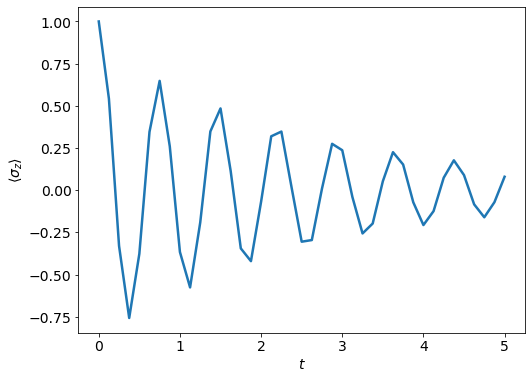

In [10]:
Omega = 8.0 # From 2.0
Gamma = 0.08 # From 0.02
system = oqupy.System(0.5 * Omega * sigma_x,
                      gammas=[Gamma],
                      lindblad_operators=[sigma_m])
params = oqupy.guess_tempo_parameters(bath=bath,
                                      start_time=t_start,
                                      end_time=t_end,
                                      tolerance=0.01)
print(params)
dynamics = oqupy.tempo_compute(system=system,
                               bath=bath,
                               initial_state=initial_state,
                               start_time=t_start,
                               end_time=t_end,
                               parameters=params)
t, s_z = dynamics.expectations(sigma_z, real=True)
plt.plot(t, s_z)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.show()

The call to `guess_tempo_parameters` returned the same set `dt=0.125`, `epsrel=6.9e-05`, `tcut=2.5` as before, because it did not use any information of the system. We can change this, and hopefully resolve the system dynamics on a more appropriate grid, by providing the system as an optional argument:

[Warning: long computation]

../oqupy/tempo.py:865: UserWarning: Estimating TEMPO parameters. No guarantee subsequent dynamics calculations are converged. Please refer to the TEMPO documentation and check convergence by varying the parameters manually.
  warnings.warn(GUESS_WARNING_MSG, UserWarning)


----------------------------------------------
TempoParameters object: Roughly estimated parameters
 Estimated with 'guess_tempo_parameters()' based on bath correlations and system frequencies (limiting).
  dt                   = 0.03125 
  tcut [dkmax]         = 2.5 [80] 
  epsrel               = 6.903e-06 
  add_correlation_time = None 

--> TEMPO computation:
100.0%  160 of  160 [########################################] 00:01:09
Elapsed time: 69.5s


Text(0, 0.5, '$\\langle\\sigma_z\\rangle$')

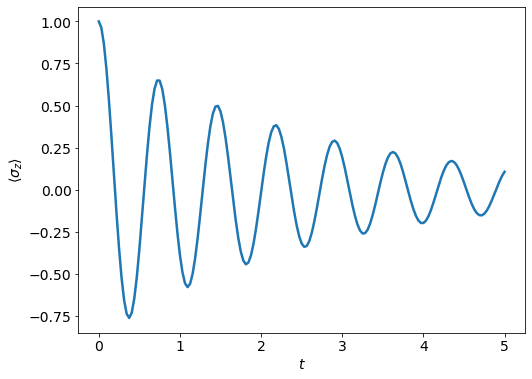

In [11]:
Omega = 8.0 # From 2.0
Gamma = 0.08 # From 0.02
system = oqupy.System(0.5 * Omega * sigma_x,
                      gammas=[Gamma],
                      lindblad_operators=[sigma_m])
params = oqupy.guess_tempo_parameters(system=system, # new system argument (optional)
                                      bath=bath,
                                      start_time=t_start,
                                      end_time=t_end,
                                      tolerance=0.01)
print(params)
dynamics = oqupy.tempo_compute(system=system,
                               bath=bath,
                               initial_state=initial_state,
                               start_time=t_start,
                               end_time=t_end,
                               parameters=params)
t, s_z = dynamics.expectations(sigma_z, real=True)
plt.plot(t, s_z)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')

As both `dkmax` increased and `epsrel` decreased to accommodate the smaller `dt=0.03125`, the computation took far longer - over a minute compared to a few seconds at `dt=0.125` (it may now be worth investigating whether a larger `epsrel` can be used).

With a `system` argument, `guess_tempo_parameters` uses the matrix norm of the system Hamiltonian and any Lindblad operators/rates to estimate a suitable timestep on which to resolve the system dynamics. This is compared to the `dt` required to meet the tolerance on error for the bath correlations, and the smaller of the two is returned. The description of the `TempoParameters` object indicates which part was 'limiting' i.e. required the smaller `dt`.

Often it is not necessary to calculate the system dynamics on such a fine grid. For example, if one only needs to calculate the steady-state polarisation. Moreover, the undersampling is easy to spot and adjust by eye. Hence you may choose to not pass a `system` object to `guess_tempo_parameters`. However, note there are cases where not accounting for system frequencies can lead to more physical features being missed, namely when the Hamiltonian or Lindblad operators/rates are (rapidly) _time-dependent._

### What sets dt, really?

The main error associated with `dt` is that from the Trotter splitting of the system propagators. In a simple (non-symmetrised) splitting, a basic requirement is
$$ [H_S(t) , H_E] dt \ll \left(H_S(t)+H_E\right) dt^2. $$
In words: error arises from non-commutation between the system and bath coupling operator. This simply reflects the fact that in the discretisation of the path integral the splitting is made between the system and environment
Hamiltonians. In cases where $H_S$ commutes with $H_E$, such as the independent boson model, $dt$ can be arbitrarily large without physical error.

Note `guess_tempo_parameters` does _not_ attempt to estimate the Trotter error, even when both `system` and `bath` objects are specified - another reason to be cautious when using the estimate produced by this function.

# Further considerations
## Additional TempoParameters arguments
For completeness, there are a few other parameters that can be passed to the `TempoParameters` constructor:
- `subdiv_limit` and `liouvillian_epsrel`. These control the maximum number of subdivisions and relative error tolerance when integrating a time-dependent system Liouvillian to construct the system propagators. It is unlikely you will need to change them from their default values (`265`, `2**(-26)`)
- `add_correlation_time`. This allows one to include correlations _beyond_ `tcut` in the final bath tensor at `dkmax` (i.e., have your finite memory cutoff cake and eat it). Doing so may provide better approximations in cases where `tcut` is limited due to computational difficultly. See [[Strathearn2017]](http://dx.doi.org/10.1088/1367-2630/aa8744) for details.

## Bath coupling degeneracies
The bath tensors in the TEMPO network are nominally $d^2\times d^2$ matrices, where $d$ is the system Hilbert space dimension. 
If there are degeneracies in the sums or differences of the eigenvalues of the system operator coupling to the environment, it is possible for the dimension of these tensors to be reduced.

Specifying `unique=True` as an argument to `oqupy.tempo_compute`, degeneracy checking is enabled: if a dimensional reduction of the bath tensors is possible, the lower dimensional tensors will be used. We expect this to provide in many cases a significant speed-up without any significant loss of accuracy, although this has not been extensively tested (new in `v0.5.0`).

## Mean-field systems
For calculating mean-field dynamics, there is an additional requirement on `dt` being small enough so not as to introduce error when integrating the field equation of motion between timesteps (2nd order Runge-Kutta). Common experience is that this is generally satisfied if `dt` is sufficiently small to avoid Trotter error. Still, you will want to at least inspect the field dynamics in addition to the system observables when checking convergence.

Note that, for the purposes of estimating the characteristic frequency of a `SystemWithField` object, `guess_tempo_parameters` uses an arbitrary complex value $\exp(i \pi/4)$ for the field variable when evaluating the system Hamiltonian. This may give a poor estimation for situations where the field variable is not of order $1$ in the dynamics.

# PT-TEMPO
The above considerations for `tcut`, `dt` and `epsrel` all apply to a PT-TEMPO computation, with the following caveats:

1. Convergence for a TEMPO computation does not necessarily imply convergence for a PT-TEMPO computation. This is important as it is often convenient to perform several one-off TEMPO computations to determine a good set of computational parameters to save having to construct many large process tensors. You can still take this approach, but must be sure to check for convergence in the PT-TEMPO computation when you have derived a reasonable set. 
2. Similar to 1., the best possible accuracy of a TEMPO and PT-TEMPO computation may be different. In particular, there may be a trade-off of accuracy for overall reduced computation time when using the PT approach. We note that the error in PT-TEMPO has also been observed ([[FowlerWright2022]](https://doi.org/10.1103/PhysRevLett.129.173001)) to become unstable at very high precisions (small `epsrel`), i.e., there may be a higher floor for how small you can make `epsrel`.
3. The computational difficultly of constructing the PT may not be monotonic with memory cutoff `dkmax` (or `tcut`). In particular, the computational time may diverge _below_ a certain `dkmax`, a.k.a, the 'dkmax anomaly'.  We highlight this counter-intuitive behaviour, which seems to occur at relatively high precisions (small `epsrel`) with short timesteps, because it may lead one to falsely believe the computation of a process tensor is not feasible. See below for a demonstration and the Supplementary Material of [[FowlerWright2022]](https://doi.org/10.1103/PhysRevLett.129.173001) for further discussion.

## The dkmax anomaly 
We consider constructing a process tensor of 250 timesteps for the harmonic environment discussed in the [Mean-Field Dynamics](https://oqupy.readthedocs.io/en/latest/pages/tutorials/mf_tempo.ipynb) tutorial, but with a smaller timestep `dt=1e-3` ps and `epsrel=1e-8` than considered there. Note that the following computations are very demanding.

In [12]:
alpha = 0.25 # Doesn't affect PT computation
nu_c = 227.9
T = 39.3
start_time = 0.0

dt = 1e-3
epsrel = 1e-8 
end_time = 250 * dt # 251 steps starting from t=0.0

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian')
bath = oqupy.Bath(oqupy.operators.sigma("z")/2.0, correlations)

We firstly set `dkmax=250` (or `None`), i.e., make no memory approximation:

In [13]:
params = oqupy.TempoParameters(dt=dt,
                               epsrel=epsrel,
                               dkmax=250)

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=params)

--> PT-TEMPO computation:
100.0%  250 of  250 [########################################] 00:01:37
Elapsed time: 97.3s


Including the full memory didn't take too long, just over one and a half minutes on a modern desktop (AMD 6-Core
processor @4.7GHz, python3.6).

What about if we now make a memory approximation, say only after `dkmax=225` timesteps:

In [14]:
params = oqupy.TempoParameters(dt=dt,
                               epsrel=epsrel,
                               dkmax=225)

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=params)

--> PT-TEMPO computation:
100.0%  250 of  250 [########################################] 00:08:04
Elapsed time: 484.6s


That was far slower (8 mins)! You can try `dkmax=200` - on my hardware the computation took half an hour; it may not be possible to complete the calculation `dkmax` much below this.

In general, there may exist some `dkmax` value (here close to 250) below which the computational time grows quickly. On the other hand, for longer computations, e.g. a 500 step process tensor, increases of `dkmax` will eventually lead to increasing compute times again, although the dynamics will surely be converged with respect to this parameter well before then.

The take-home message is to not discount that a stalling PT computation may in fact be possible with an increase in the memory length. In these situations one approach is to start with `dkmax=None` and work backwards to find the `dkmax` offering the minimum compute time (before the rapid increase).